## Sentiment Analysis for LEVI's jeans

### Initial setup

In [9]:
import csv
import pandas as pd
import numpy as np
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
import re
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import langid
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from matplotlib import pyplot as plt

### Functions

In [10]:
def textPreProcess(rawText, removeHTML=True, charsToRemove = r'\?|\.|\!|\;|\.|\"|\,|\'|\(|\)|\&|\:|\-', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove = r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True):
    cleanedText = []
    for x in (rawText[:]): 
        
        # Remove HTML
        if removeHTML:
            procText = BeautifulSoup(x,'html.parser').get_text()

         # Remove punctuation and other special characters
        if len(charsToRemove)>0:
            procText = re.sub(charsToRemove,' ',procText)

        # Remove numbers
        if removeNumbers:
            procText = re.sub(r'\d+',' ',procText)

        # Remove line breaks
        if removeLineBreaks:
            procText = procText.replace('\n',' ').replace('\r', '')

        # Remove special characters
        if len(specialCharsToRemove)>0:
            procText = re.sub(specialCharsToRemove,' ',procText)

        # Normalize to lower case
        if convertToLower:
            procText = procText.lower() 

        # Replace multiple consecutive spaces with just one space
        if removeConsecutiveSpaces:
            procText = re.sub(' +', ' ', procText)

        # If there is a text, add it to the clean text         
        if procText != '':
            cleanedText.append(procText)
    return cleanedText

def tokenize_words(texts):
    words_new = []
    for w in (texts[:]):
        w_token = word_tokenize(w)
        if w_token != '':
            words_new.append(w_token)
    return words_new

def recreateText(words):
    text_new = []
    for w in (words[:]):
        temp_str = (' ').join(w)
        text_new.append(temp_str)
    return text_new

def tokenize_sentences(texts):
    sentences_new = []
    for s in (texts[:]):
        s_token = sent_tokenize(s)
        sentences_new.append(s_token)
    return sentences_new

def removeStopWords(texts, stop_words):
    procText = []
    for t in (texts[:]):
        cleaned_text = [w for w in t[:] if not w in stop_words]
        procText.append(cleaned_text)
    return procText

def common_data(list1, list2):
    result = False
    for x in list1:
        for y in list2:
            if x == y:
                result = True
                return result
    return result

#  Importar xls

### Antes

In [17]:
dados_antes= pd.read_excel("Antes.xlsx", engine= 'openpyxl')

In [18]:
keywords=['Delivery','Service','Supply','Shipping','Transport','Deliverance','Bringing','Transfer','Transportation','Shipment','Availability','Fast','Slow','Quick'
,'Speed','Time','Delay','Distribution','Providing','Flow','Dropped','Trading','Forwarding','Receipt','Arrival','Pickup']
keywords = [low.lower() for low in keywords ]

# ETL Das tabelas

In [19]:
dados_antes.dropna(subset=['Comentário'],inplace=True)
dados_antes['Comentário']=dados_antes['Comentário'].astype(str)
dados_antes['comentarios_limpos']=textPreProcess(dados_antes['Comentário'])
dados_antes=dados_antes.drop(['Unnamed: 5','Unnamed: 6'],axis=1)

# Detecção da Linguagem - Antes

In [20]:
languagelist=[]
for texto in [*dados_antes['comentarios_limpos']]:
    language=langid.classify(texto)
    languagelist.append(language)
languagelist=[language[0] for language in languagelist]
dados_antes['language']=languagelist
dados_en_antes=dados_antes.query("language=='en'")

# Analysis

### Antes

In [22]:
# Get words
dados_en_antes['Words'] =  tokenize_words(dados_en_antes['comentarios_limpos'])

# Remove stopwords
stop_words = set(stopwords.words('english'))
dados_en_antes['WordsCleaned'] = removeStopWords(dados_en_antes['Words'], stop_words)

key=dados_en_antes.apply(lambda x: common_data(x['WordsCleaned'],keywords),axis=1)
dados_en_antes['haskeyword']=key
tamanho_total = len(dados_en_antes)
dados_en_antes=dados_en_antes.query("haskeyword==True")
tamanho_com_keywords = len(dados_en_antes)
dados_en_antes=dados_en_antes.reset_index(drop=True)

# Recreate sentence without stopwords
dados_en_antes['ProcessedText'] = recreateText(dados_en_antes['WordsCleaned'])

dados_removidos = tamanho_total - tamanho_com_keywords

print("Total de dados antes: ",tamanho_total)
print("Total de comentários removidos: ", dados_removidos)
print("Total de comentários analisados: ", tamanho_com_keywords)

Total de dados antes:  6454
Total de comentários removidos:  5981
Total de comentários analisados:  473


In [27]:
analyser = SentimentIntensityAnalyzer()
# To test, let's evaluate first sentence of first review
# Scales:
#   compound: -1:most extreme negative, 
#   1:most extreme positive
#     positive: compound >=0.05
#     neutral: -0.05<compound<0.05
#     negative: compound <= -0.05
# #   pos, neu, neg: proportion of text that are positive, neutral or negative
# score = analyser.polarity_scores(dados_en['ProcessedText'][1])
# print(dados_en['ProcessedText'][1],score)

all_scores = []
for t in (dados_en_antes['ProcessedText']):
    score = analyser.polarity_scores(t)
    all_scores.append(score)
dados_en_antes['Sentiment'] = [c['compound'] for c in all_scores]
dados_en_antes['Positive'] = [c['pos'] for c in all_scores]
dados_en_antes['Negative'] = [c['neg'] for c in all_scores]
dados_en_antes['Neutral'] = [c['neu'] for c in all_scores]

average_antes=dados_en_antes[['comentarios_limpos','Avaliação','Sentiment']].groupby('Avaliação').mean()[['Sentiment']]

bins = pd.IntervalIndex.from_tuples([(-1.1, -0.05), (-0.05, 0.05), (0.05, 1)], closed='right')
x = pd.cut(dados_en_antes['Sentiment'].to_list(), bins)
x.categories = ['Negative','Neutral','Positive']
dados_en_antes['Polarity'] = x

In [30]:
dados_en_antes.head(3)

,CH1,Comentário,Avaliação,Data,Autor,comentarios_limpos,language,Words,WordsCleaned,haskeyword,ProcessedText,Sentiment,Polarity,Positive,Negative,Neutral
0,CH1,Big mistake on my part. I forgot that Levi's 5...,"1,0 de 5 estrelas",Avaliado nos Estados Unidos em 11;abril;2019,D. Harmon,big mistake on my part i forgot that levi s je...,en,"[big, mistake, on, my, part, i, forgot, that, ...","[big, mistake, part, forgot, levi, jeans, awkw...",True,big mistake part forgot levi jeans awkward dif...,0.2247,Positive,0.167,0.153,0.681
1,CH1,While they fit as expected a belt loop broke t...,"1,0 de 5 estrelas",Avaliado nos Estados Unidos em 30;setembro;2019,Mike,while they fit as expected a belt loop broke t...,en,"[while, they, fit, as, expected, a, belt, loop...","[fit, expected, belt, loop, broke, second, tim...",True,fit expected belt loop broke second time wore ...,0.1027,Positive,0.105,0.070,0.825
2,CH1,This review is for the Dark Stonewash and Dark...,"3,0 de 5 estrelas",Avaliado nos Estados Unidos em 16;janeiro;2019,SAM,this review is for the dark stonewash and dark...,en,"[this, review, is, for, the, dark, stonewash, ...","[review, dark, stonewash, dark, charcoal, garm...",True,review dark stonewash dark charcoal garment dy...,0.7579,Positive,0.130,0.024,0.845


In [31]:
average_antes

,Sentiment
Avaliação,
"1,0 de 5 estrelas",0.098223
"2,0 de 5 estrelas",0.326625
"3,0 de 5 estrelas",0.313139
"4,0 de 5 estrelas",0.591498
"5,0 de 5 estrelas",0.702391


# Agora, aplicando a análise para o arquivo "Durante"

In [42]:
dados_durante= pd.read_excel("Durante.xlsx", engine='openpyxl')

dados_durante.dropna(subset=['Comentário'],inplace=True)
dados_durante['Comentário']=dados_durante['Comentário'].astype(str)
dados_durante['comentarios_limpos']=textPreProcess(dados_durante['Comentário'])
dados_durante=dados_durante.drop(['Unnamed: 5','Unnamed: 6'],axis=1)

languagelist=[]
for texto in [*dados_durante['comentarios_limpos']]:
    language=langid.classify(texto)
    languagelist.append(language)
languagelist=[language[0] for language in languagelist]
dados_durante['language']=languagelist
dados_en_durante=dados_durante.query("language=='en'")

In [43]:
dados_en_durante['Words'] =  tokenize_words(dados_en_durante['comentarios_limpos'])

# Remove stopwords
stop_words = set(stopwords.words('english'))
dados_en_durante['WordsCleaned'] = removeStopWords(dados_en_durante['Words'], stop_words)

key=dados_en_durante.apply(lambda x: common_data(x['WordsCleaned'],keywords),axis=1)
dados_en_durante['haskeyword']=key
tamanho_total = len(dados_en_durante)
dados_en_durante=dados_en_durante.query("haskeyword==True")
tamanho_com_keywords = len(dados_en_durante)
dados_en_durante=dados_en_durante.reset_index(drop=True)
dados_en_durante['ProcessedText'] = recreateText(dados_en_durante['WordsCleaned'])


dados_removidos = tamanho_total - tamanho_com_keywords

print("Total de dados antes: ",tamanho_total)
print("Total de comentários removidos: ", dados_removidos)
print("Total de comentários analisados: ", tamanho_com_keywords)

Total de dados antes:  6125
Total de comentários removidos:  5678
Total de comentários analisados:  447


In [44]:
analyser = SentimentIntensityAnalyzer()

all_scores = []
for t in (dados_en_durante['ProcessedText']):
    score = analyser.polarity_scores(t)
    all_scores.append(score)
dados_en_durante['Sentiment'] = [c['compound'] for c in all_scores]
dados_en_durante['Positive'] = [c['pos'] for c in all_scores]
dados_en_durante['Negative'] = [c['neg'] for c in all_scores]
dados_en_durante['Neutral'] = [c['neu'] for c in all_scores]

average_durante=dados_en_durante[['comentarios_limpos','Avaliação','Sentiment']].groupby('Avaliação').mean()[['Sentiment']]

bins = pd.IntervalIndex.from_tuples([(-1.1, -0.05), (-0.05, 0.05), (0.05, 1)], closed='right')
x = pd.cut(dados_en_durante['Sentiment'].to_list(), bins)
x.categories = ['Negative','Neutral','Positive']
dados_en_durante['Polarity'] = x

dados_en_durante.head(3)

,CH1,Comentário,Avaliação,Data,Autor,comentarios_limpos,language,Words,WordsCleaned,haskeyword,ProcessedText,Sentiment,Positive,Negative,Neutral,Polarity
0,CH1,DENIM QUALITY. These are not the Levi's I grew...,"1,0 de 5 estrelas",Avaliado nos Estados Unidos em 16;julho;2021,IdyGal,denim quality these are not the levi s i grew ...,en,"[denim, quality, these, are, not, the, levi, s...","[denim, quality, levi, grew, wearing, denim, t...",True,denim quality levi grew wearing denim thin mak...,0.6705,0.121,0.072,0.807,Positive
1,CH1,I have no idea what planet these people writin...,"5,0 de 5 estrelas",Avaliado nos Estados Unidos em 24;agosto;2021,D. Metz,i have no idea what planet these people writin...,en,"[i, have, no, idea, what, planet, these, peopl...","[idea, planet, people, writing, negative, revi...",True,idea planet people writing negative reviews li...,0.7605,0.112,0.058,0.830,Positive
2,CH1,My husband has had a difficult time finding Le...,"5,0 de 5 estrelas",Avaliado nos Estados Unidos em 27;abril;2020,Linda J. Macdonald,my husband has had a difficult time finding le...,en,"[my, husband, has, had, a, difficult, time, fi...","[husband, difficult, time, finding, levi, size...",True,husband difficult time finding levi size last ...,0.8784,0.231,0.095,0.673,Positive


#  Resultados - Data Visualization 

Vimos que durante o COVID a análise de sentimento relacionada a logistica das calças Levi's tiveram um aumento positivo

In [45]:
dados_en_durante['label']='durante'
dados_en_antes['label']='antes'
all_data = pd.concat([dados_en_antes, dados_en_durante],axis=0) 

<AxesSubplot:xlabel='label', ylabel='Sentiment'>

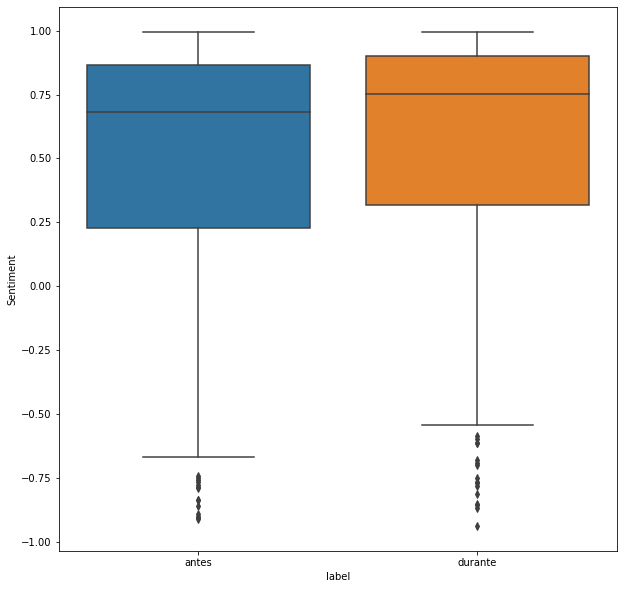

In [46]:
plt.figure(figsize=(10,10))
sns.boxplot(data=all_data,y='Sentiment',x='label')

<AxesSubplot:xlabel='Avaliação', ylabel='Sentiment'>

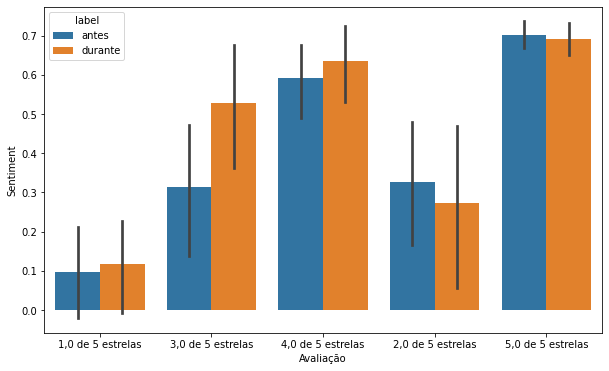

In [51]:
plt.figure(figsize=(10,6))
sns.barplot(data=all_data,y='Sentiment',x='Avaliação',hue='label')

<AxesSubplot:xlabel='label', ylabel='Positive'>

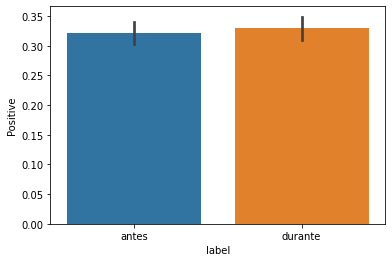

In [52]:
sns.barplot(data=all_data,y='Positive',x='label')